# CS 229 project : Calvin, Zozo & Lilie

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline 

### Chosing parameters of simulation

In [2]:
country = 'France'
timestep = 1 # [h]
horizon = 24 # [h] We want the model for be efficient for 24 
hours_of_data = 30*24 # [h]
#algo = ? # among ['value_iteration','Approximate Q-learning','Fuzzy Q-learning' ]

### Loading data

In [3]:
from utilities import *
file_solar = "../data/solar.xls" # w
file_wind = "../data/wind.xls" # MW
file_price = "../data/price.xlsx" # euro / MW

tableau = pd.DataFrame(generate_table(file_solar, file_wind, file_price, country))
price_dataset=tableau[3][:]
solar_dataset=tableau[1][:]
wind_dataset =tableau[2][:]

### Converting units

In [4]:
solar_dataset = solar_dataset.values * 1000 # mW -> kW
wind_dataset = wind_dataset.values * 1000
price_dataset = price_dataset.values / 1000 # euro/mW -> euro/kW
prod_dataset = wind_dataset + price_dataset

### Normalizing data

In [5]:
desired_prod_max= 10000 #kW
#desired_prod_std= 50
#normalized_prod_dataset = (prod_dataset - prod_dataset.mean())/prod_dataset.std()*desired_prod_std + desired_prod_mean
normalized_prod_dataset = desired_prod_max * (wind_dataset/wind_dataset.max() + solar_dataset/solar_dataset.max())
normalized_price_dataset= price_dataset

### Splitting data

In [6]:
# We have data for 1 month
# So we can split the data as such : 26 days for training set , 2 days for dev set, 2 days for test set

#First we form day sequences of data
day_split_prod = [normalized_prod_dataset[24*i:24*(i+1)] for i in range(30)]
day_split_price = [normalized_price_dataset[24*i:24*(i+1)] for i in range(30)]

# (Optional) We shuffle
#np.random.seed(0)
#random_order = np.random.permutation(range(30))
random_order = list(range(30))

#Splitting data
prod_train = [day_split_prod[i] for i in random_order[4:]]
prod_val = [day_split_prod[i] for i in random_order[2:4]]
prod_test = [day_split_prod[i] for i in random_order[0:2]]

price_train = [day_split_price[i] for i in random_order[4:]]
price_val = [day_split_price[i] for i in random_order[2:4]]
price_test = [day_split_price[i] for i in random_order[0:2]]

### Chosing the discretizations

In [8]:
# STATES
discrete_battery=np.linspace(0,100,10)
discrete_vessel=np.linspace(0,100,10)
discrete_grid_price=np.linspace(min(normalized_price_dataset),max(normalized_price_dataset),10) # euro/kW
discrete_prod=np.linspace(min(normalized_prod_dataset),max(normalized_prod_dataset),10) # kW


#ACTIONS
discrete_elec_regime=np.linspace(20,40,8)# % of max rate production of electrolyzer
discrete_buy_sell=np.linspace(-10,10,8)# % of battery capacity

n_states=24*len(discrete_battery)*len(discrete_vessel)*len(discrete_grid_price)*len(discrete_prod)*len(discrete_elec_regime)
n_actions=len(discrete_elec_regime)*len(discrete_buy_sell)
print("Number of actions :",n_actions)
print("Number of states :",n_states)

Number of actions : 64
Number of states : 1920000


### Building the environment

In [9]:
import pickle
from environment.SupplyChainEnv import SupplyChainEnv
from experiment.experiment import  Experiment
from learner.interface import ActionValueTable
from explorer.egreedy import EpsilonGreedyExplorer
from agent.learning import LearningAgent
from learner.q import Q
from environment.SupplyTask import SupplyTaskMDP
from agent.logging import LoggingAgent

In [9]:
#learner = Q(epsilon=0.5) # comes by default with explorer = EpsilonGreedyExplorer(epsilon = 0.3, decay = 0.9999)
agent=pickle.load(open('models/agent_nfq.txt','rb'))
#agent = LearningAgent(controller, learner)

In [10]:
environment = SupplyChainEnv(prod_train[0],price_train[0],discrete_battery,discrete_vessel,discrete_elec_regime,discrete_grid_price,discrete_prod,discrete_buy_sell)
task = SupplyTaskMDP(environment)

Initial battery load : 21212.121212121212  kW.h
Initial vessel load : 202.02020202020202  kg
Initial electrolyzer regime : 28.88888888888889


In [11]:
experiment = Experiment(task, agent)

### Evaluation of the model

In [12]:
def eval_agent(agent,environment,experiment,prod_val,price_val,horizon=24):
    # Loop over all the evaluation days
    utilities = []
    battery_states = []
    flow_g = []
    regime_e = []
    h2_vessel_states = []
    for prod,price in zip(prod_val,price_val):
        agent.reset()
        environment.reset(prod,price)
        print(environment.h2_vessel.current_load)
        battery_states_day,h2_vessel_states_day,regime_e_day,flow_g_day=experiment.doInteractions(horizon,test=True)
        
        samples= agent.learner.dataset
        r=0
        for seq in samples:
            for _,_,reward in seq:
                r+=reward
        utilities.append(r)
        battery_states.append(battery_states_day)
        h2_vessel_states.append(h2_vessel_states_day)
        flow_g.append(flow_g_day)
        regime_e.append(regime_e_day)
    return utilities,battery_states,h2_vessel_states,flow_g,regime_e

In [13]:
#Validation set
utilities,battery_states,h2_vessel_states,flow_g,regime_e = eval_agent(agent,environment,experiment,[normalized_prod_dataset[0:48]],[normalized_price_dataset[0:48]],horizon=48)

50.505050505050505
Sequence of chosen actions:
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]
[98.]


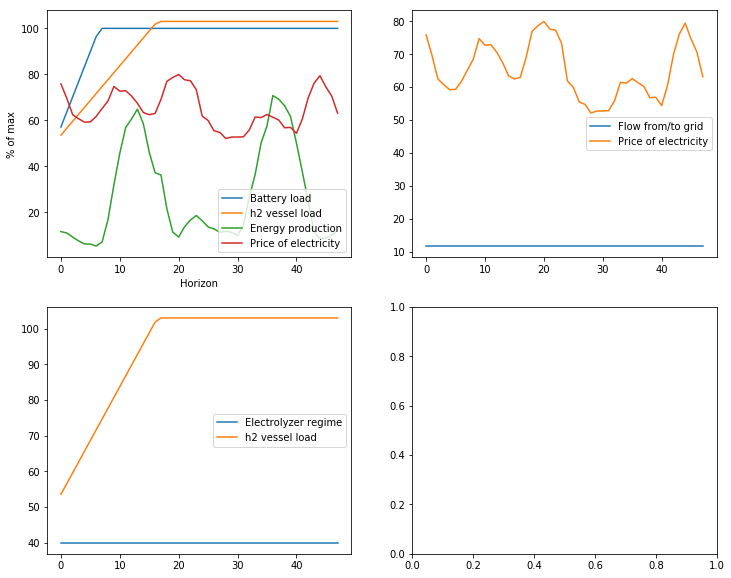

In [14]:
day=0

fig, axs = plt.subplots(2,2,figsize=(12,10))
axs[0,0].plot(battery_states[day])
axs[0,0].plot(h2_vessel_states[day])
axs[0,0].plot(normalized_prod_dataset[0:48]/max(normalized_prod_dataset)*100)
axs[0,0].plot(normalized_price_dataset[0:48]/max(normalized_price_dataset)*100)
axs[0,0].set_xlabel("Horizon")
axs[0,0].set_ylabel("% of max")
axs[0,0].legend(('Battery load','h2 vessel load','Energy production','Price of electricity'),loc='lower right')

axs[0,1].plot(flow_g[day][:])
axs[0,1].plot(normalized_price_dataset[0:48]/max(normalized_price_dataset)*100)
axs[0,1].legend(('Flow from/to grid','Price of electricity'))

axs[1,0].plot(regime_e[day][:])
axs[1,0].plot(h2_vessel_states[day][:])
axs[1,0].legend(('Electrolyzer regime','h2 vessel load'))

#eval_rewards[eval_rewards<-100]= -0.05
#axs[1,1].plot(eval_rewards)
#axs[1,1].set_ylabel("Evaluation reward")
#axs[1,1].set_xlabel("Epochs")
#plt.show()